In [22]:
import pandas as pd
import bz2
from sklearn.metrics import f1_score,classification_report
from sklearn.neural_network import MLPClassifier



In [ ]:
dataset = pd.read_csv("train_data_percentage", index_col=0)
dataset = dataset.dropna()
dataset = (dataset[(dataset.lang=="en")]).reset_index(drop=True).sort_index()
dataset = dataset.reset_index(drop=True).sort_index()

In [2]:
# Create categories from priceChanges
stepKey = "1stepChange"
threshold = 0.005
dataset.insert(loc=9,column="priceChangeClass", value=1)
dataset.at[dataset[dataset[stepKey] <= (1-threshold)].index, "priceChangeClass"] = 0
dataset.at[dataset[dataset[stepKey] >= (1+threshold)].index, "priceChangeClass"] = 2

In [3]:
smallest_amount_data = min(dataset.priceChangeClass.value_counts())

indexes = []
for unique_class in set(dataset.priceChangeClass):
        temp_indexes = dataset.loc[dataset.priceChangeClass==unique_class].sample(smallest_amount_data).index
        #print(list(temp_indexes))
        indexes += list(temp_indexes)

In [4]:
# Pick out indexes, shuffle rows, and reset indexes
balanced_dataset = dataset.loc[indexes].sample(frac=1).reset_index(drop=True)
balanced_dataset.iloc[195698].summary

'Stocks that moved heavily or traded substantially Thursday:'

In [5]:
seed = 12345

val_percent = 0.1
test_percent = 0.2

validation_data = (balanced_dataset.sample(frac=val_percent, random_state=seed)).reset_index(drop=True)
test_data = (balanced_dataset.sample(frac=test_percent, random_state=seed)).reset_index(drop=True)
train_data = (balanced_dataset.iloc[balanced_dataset.index.difference(test_data.index).difference(validation_data.index)]).reset_index(drop=True)

In [6]:
train_data['priceChangeClass'].value_counts()

2    52217
1    52174
0    52168
Name: priceChangeClass, dtype: int64

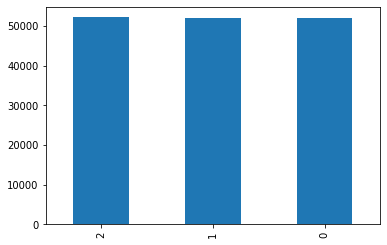

In [7]:
import matplotlib.pyplot as plt
train_data['priceChangeClass'].value_counts().plot(kind='bar');

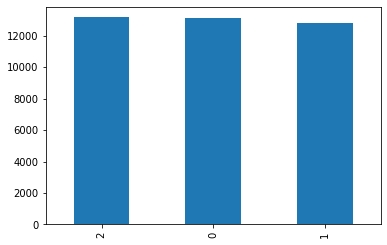

In [8]:
test_data['priceChangeClass'].value_counts().plot(kind='bar');

## Naive Bayes classifier¶

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
steps= [('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())]
pipeline = Pipeline(steps)
pipeline.fit(train_data.summary, train_data.priceChangeClass)

Pipeline(steps=[('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())])

In [11]:
pipeline.score(test_data.summary, test_data.priceChangeClass)

0.5196985181400102

In [12]:
steps= [('vec', TfidfVectorizer()), ('multinomialnb', MultinomialNB())]
pipeline2 = Pipeline(steps)
pipeline2.fit(train_data.summary, train_data.priceChangeClass)

Pipeline(steps=[('vec', TfidfVectorizer()), ('multinomialnb', MultinomialNB())])

In [13]:
pipeline2.score(test_data.summary, test_data.priceChangeClass)

0.5283341849770056

(array([11986.,     0.,     0.,     0.,     0., 15567.,     0.,     0.,
            0., 11587.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

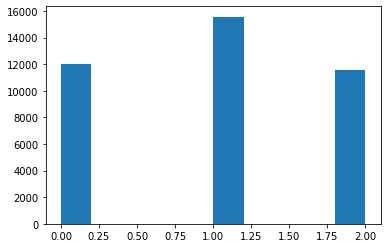

In [14]:
predicted = pipeline.predict(test_data.summary)
plt.hist(predicted)

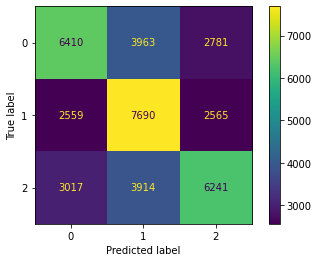

In [15]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(pipeline, test_data.summary, test_data.priceChangeClass)


## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(train_data.summary, train_data.priceChangeClass)
dummy_clf.score(test_data.summary, test_data.priceChangeClass)

0.3310935104752172

An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [17]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_data.summary, train_data.priceChangeClass)
dummy_clf.score(test_data.summary, test_data.priceChangeClass)



0.33653551354113437

## Problem 4: Creating a balanced data set

## Problem 5: Confusion matrix

In [19]:
from sklearn.model_selection import GridSearchCV

steps= [('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())]
new_pipeline = Pipeline(steps)
#a = GridSearchCV(estimator=new_pipeline, param_grid={"vec__binary": [True, False],"vec__ngram_range":[(1,1), (1,2)], 
#                                                     "multinomialnb__alpha":[1,0.1]})
new_pipeline.fit(train_data.summary, train_data.priceChangeClass)


Pipeline(steps=[('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())])

In [20]:
#print(a.best_params_)
new_pipeline.score(test_data.summary,test_data.priceChangeClass)

0.5202861522738886

## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model. Did you manage to get better results than the ones that you obtained in Problem&nbsp;6? Answer with a short text.

In [81]:
from sklearn.svm import SVC

steps = [('vec', CountVectorizer()), ('svc',  SVC())]

#parameters = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}

pipeline = Pipeline(steps)

#clf = GridSearchCV(pipeline, parameters)
pipeline.fit(train_data.summary[:5000], train_data.priceChangeClass[:5000])


Pipeline(steps=[('vec', CountVectorizer()), ('svc', SVC())])

In [89]:
#print(pipeline.best_params_)
pipeline.score(test_data.summary,test_data.priceChangeClass)

NotFittedError: Vocabulary not fitted or provided

In [103]:
from sklearn.neural_network import MLPClassifier

steps = [('vec', TfidfVectorizer()), ('net',  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,10), random_state=1,max_iter=3000))]
pipeline = Pipeline(steps)
pipeline.fit(train_data.summary, train_data.priceChangeClass)


/home/hugo/.virtualenvs/stock-news/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('vec', TfidfVectorizer()),
                ('net',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15, 10),
                               max_iter=3000, random_state=1,
                               solver='lbfgs'))])

In [104]:
pipeline.score(test_data.summary,test_data.priceChangeClass)

0.762008175779254

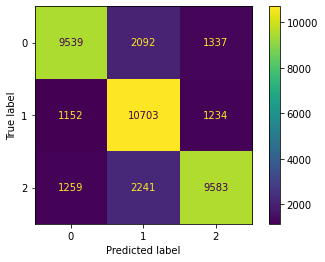

In [105]:
plot_confusion_matrix(pipeline, test_data.summary, test_data.priceChangeClass)

In [106]:
from sklearn.metrics import f1_score,classification_report

res = pipeline.predict(test_data.summary)

print(classification_report(test_data.priceChangeClass, res))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     12968
           1       0.71      0.82      0.76     13089
           2       0.79      0.73      0.76     13083

    accuracy                           0.76     39140
   macro avg       0.77      0.76      0.76     39140
weighted avg       0.77      0.76      0.76     39140



## With countvectorizer

In [46]:

steps = [('vec', CountVectorizer()), ('net',  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,10,10,10,10), random_state=1,max_iter=3000))]
pipeline = Pipeline(steps)
pipeline.fit(train_data.summary, train_data.priceChangeClass)

/home/hugo/.virtualenvs/stock-news/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('vec', CountVectorizer()),
                ('net',
                 MLPClassifier(alpha=1e-05,
                               hidden_layer_sizes=(15, 10, 10, 10, 10),
                               max_iter=3000, random_state=1,
                               solver='lbfgs'))])

In [47]:
pipeline.score(test_data.summary,test_data.priceChangeClass)

0.7543433827286663

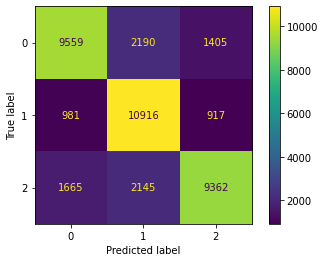

In [40]:


plot_confusion_matrix(pipeline, test_data.summary, test_data.priceChangeClass)

In [41]:
res = pipeline.predict(test_data.summary)

print(classification_report(test_data.priceChangeClass, res))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     13154
           1       0.72      0.85      0.78     12814
           2       0.80      0.71      0.75     13172

    accuracy                           0.76     39140
   macro avg       0.77      0.76      0.76     39140
weighted avg       0.77      0.76      0.76     39140



In [42]:
text = test_data.iloc[20:50]
res = pipeline.predict(text.summary)
print(res)
print(text.priceChangeClass.to_numpy())

[1 0 2 2 1 0 0 0 1 1 1 1 2 0 0 0 0 2 0 1 1 1 2 1 2 0 2 1 0 0]
[1 0 2 2 0 0 0 0 1 1 1 1 2 0 0 2 1 0 0 1 1 1 2 2 2 1 2 1 2 0]


In [43]:
test_data

,datetime,headline,summary,related,lang,source,1stepChange,2stepChange,3stepChange,priceChangeClass,6stepChange
0,2020-09-22 01:00:16-05:00,"Snap has registered 750,000 people to vote in ...","Teaming up with artist Mark Bradford, Snapchat...",SNAP,en,Fast Company,1.000418,1.003763,1.002508,1,1.001254
1,2020-01-30 09:21:21-05:00,Agnico Eagle Mines Limited : Towards the break...,Agnico Eagle Mines Limited shares are closing ...,AEM,en,MarketScreener,0.996059,1.002982,1.003284,1,1.022250
2,2019-11-06 00:12:59-05:00,Outgoing NYPD Commissioner James O’Neill to jo...,Police Commissioner James O’Neill will head Vi...,V,en,New York Post,1.002438,1.000454,1.002438,1,1.003459
3,2020-02-07 13:42:12-05:00,Crypto Today: Ethereum rockets higher with fur...,Here's what you need to know on Friday Markets...,ETH,en,Forex Crunch,0.993416,0.996842,0.998212,0,0.993416
4,2019-07-23 08:12:21-05:00,"What You Need To Know About TurnKey, Amazon's ...",Real estate services company Realogy Holdings ...,RLGY,en,Benzinga,0.961252,0.941878,0.959762,0,0.858420
...,...,...,...,...,...,...,...,...,...,...,...
39135,2020-05-07 06:53:49-05:00,Indian education platform Unacademy’s database...,"Unacademy, one of India’s largest learning sit...",INFY,en,The Next Web,1.010193,1.015855,1.019819,2,1.018686
39136,2020-03-31 08:30:02-05:00,"Snapchat launches App Stories, which lets deve...",Josh Constine / TechCrunch : Snapchat launches...,SNAP,en,Techmeme,1.004292,0.990558,1.040343,1,1.054506
39137,2019-02-06 09:50:26-05:00,Can A High-Yield Allocation Still Offset Equit...,No summary available.,"JSD,JQC",en,Seeking Alpha,1.000000,1.000425,1.001610,1,1.000644
39138,2019-04-15 17:12:00-05:00,"PG&E Shares, Bonds Surge on Governor’s Wildfir...",PG&E Corp.’s stock and bond prices have surged...,PCG,en,The Wall Street Journal,1.000424,0.995335,0.993215,1,1.019932
